In [1]:
# to compile and serve:
# ipython nbconvert pydata-slides.ipynb --to slides --post serve


# Exploring the Panama Papers Network

Amsterdam Pydata Meetup 

2016-12-08

[Iain Barr](mailto:iain@degeneratestate.org)

## Overview
- What are the Panama Papers
- Why am I talking about Exploratory Data Analysis
- Graphs
- Exploring Data

This presentation is based on the work completed during a hackathon run by transparency international in May 2016.

The original write-up is [here](http://www.degeneratestate.org/posts/2016/Jun/30/exploring-the-panama-papers-network/)

This presentation is online at [www.degeneratestate.org/static/presentations/pppd2016.html](http://www.degeneratestate.org/static/presentations/pppd2016.html)

# The Panama Papers: What?

In 2016, the [International Consortium of Investigative Journalists](https://www.icij.org/)(ICIJ) published details of the panama papers. They covered leaked documents from the Panamanian law firm [Mossack Fonseca](https://en.wikipedia.org/wiki/Mossack_Fonseca), detailing their business dealings.

- 11 million documents
- 2.6 Terabytes of data
- Largest leak in histroy

# The Panama Papers: Why?

>“Previously, we thought that the offshore world was a shadowy, but minor, part of our economic system. What we learned from the Panama Papers is that it is the economic system.”

[Quote from Panama: the hidden trillions](http://www.nybooks.com/articles/2016/10/27/panama-the-hidden-trillions/)

> "Ninety-five per cent of our work coincidentally consists in selling vehicles to avoid taxes."

[leaked memorandum from a partner of Mossack Fonseca](https://www.theguardian.com/news/2016/apr/03/the-panama-papers-how-the-worlds-rich-and-famous-hide-their-money-offshore)

# The Panama Papers: Obligitory Disclaimer

Morality aside, there are perfectly legal reasons to have an offshore account. 

I want to emphasis that:

**I am not accusing any individuals or companies that appear in this presentation or in the original dataset of wrong doing**.

# The Panama Papers: Links

What: 
- https://panamapapers.icij.org/
- https://www.theguardian.com/news/2016/apr/03/the-panama-papers-how-the-worlds-rich-and-famous-hide-their-money-offshore
- http://www.nybooks.com/articles/2016/10/27/panama-the-hidden-trillions/
- https://www.theguardian.com/news/2016/apr/03/a-world-of-hidden-wealth-why-we-are-shining-a-light-offshore
- http://www.npr.org/sections/money/2016/03/30/472452808/episode-403-what-can-we-do-with-our-shell-companies
- https://www.theguardian.com/business/2015/jun/19/tax-havens-money-cayman-islands-jersey-offshore-accounts
- http://www.theatlantic.com/business/archive/2015/10/elite-wealth-management/410842/
    
Who: 
- https://panamapapers.icij.org/the_power_players/
- https://en.wikipedia.org/wiki/List_of_people_named_in_the_Panama_Papers

# Exploratory Data Analysis

> "Procedures for analyzing data, techniques for interpreting the results of such procedures, ways of planning the gathering of data to make its analysis easier, more precise or more accurate, and all the machinery and results of (mathematical) statistics which apply to analyzing data." - John Tukey

# Graphs

Formally, a graph is defined by the ordered pair $G = (V,E)$, where:
- $V$ is a set of vertices
- $E$ is a set of pairs of verticies

Edges can be directed or undirected.

# Graphs in Python

We will be using the library [NetworkX](https://networkx.github.io/) to explore the data. 

NetworkX keeps the graph in memory. For this dataset this isn't an issues, however it may become impractical for larger datasets. Similar approachs to those presented here should work with distributed graph representations such as [GraphX](https://networkx.github.io/).

# Graphs in Python

In [2]:
import networkx as nx

# Create a simple undirected graph
g = nx.Graph()
g.add_nodes_from([1,2,3])
g.add_edges_from([(1,2), (2,3), (3,1)])

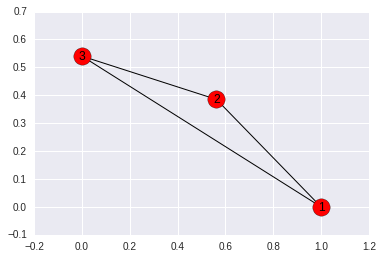

In [3]:
# and plot it
import matplotlib.pyplot as plt
import seaborn as sns # this isn't actually required, but it makes our plots look nice
%matplotlib inline

nx.draw_networkx(g)

# The Data

[The data](https://offshoreleaks.icij.org/) released wasn't the raw data, but preprocessed data in the format of a directed graph. The nodes represent things, and the edge represent relationships between things.

Nodes
 - address
 - entities
 - intermediates
 - officers

Edges
 - intermediary of
 - registered address
 - shareholder of
 - Records & Registers of
 - etc

In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

import random

%matplotlib inline
import matplotlib as mpl
mpl.style.use("ggplot")

%load_ext autoreload
%autoreload 2

from pputils import *

In [2]:
# Loading the data into pandas for easy processing
adds = pd.read_csv("data/Addresses.csv", low_memory=False)

ents = pd.read_csv("data/Entities.csv", low_memory=False)
ents["name"] = ents.name.apply(normalise)

inter = pd.read_csv("data/Intermediaries.csv", low_memory=False)
inter["name"] = inter.name.apply(normalise)

offi = pd.read_csv("data/Officers.csv", low_memory=False)
offi["name"] = offi.name.apply(normalise)

edges = pd.read_csv("data/all_edges.csv", low_memory=False)

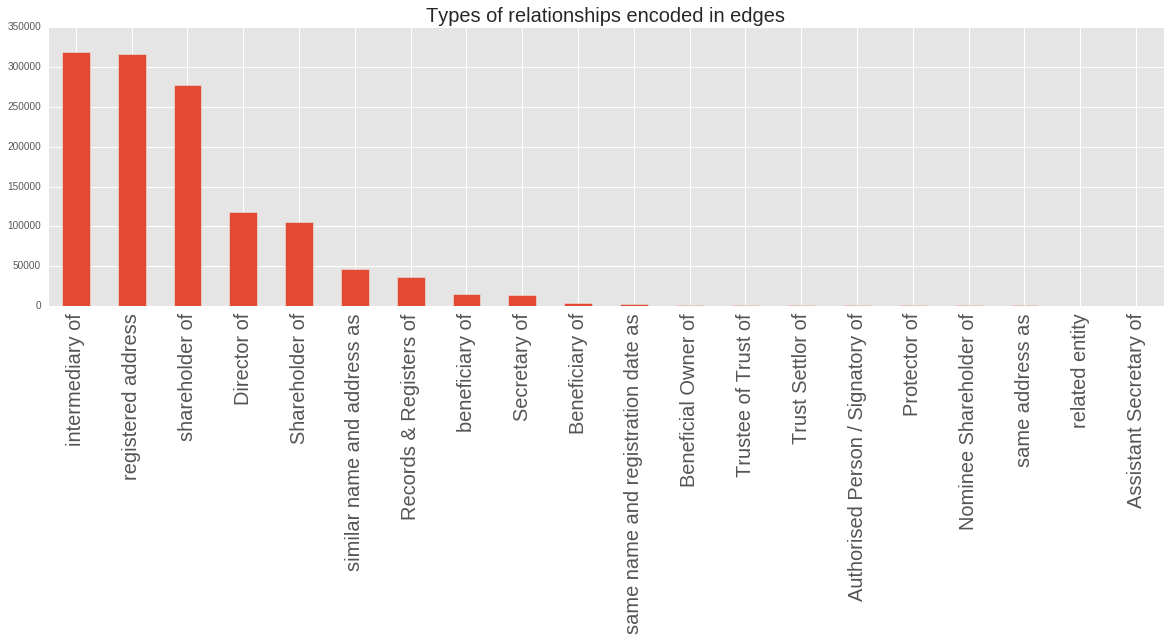

In [6]:
# With the nodes and edges in pandas, we can quickly explore various properties
# such as looking at the different types of nodes
edges.rel_type.value_counts()[:20].plot(kind="bar", figsize=(20,5))
plt.title("Types of relationships encoded in edges", fontsize=20)
plt.xticks(fontsize=20);

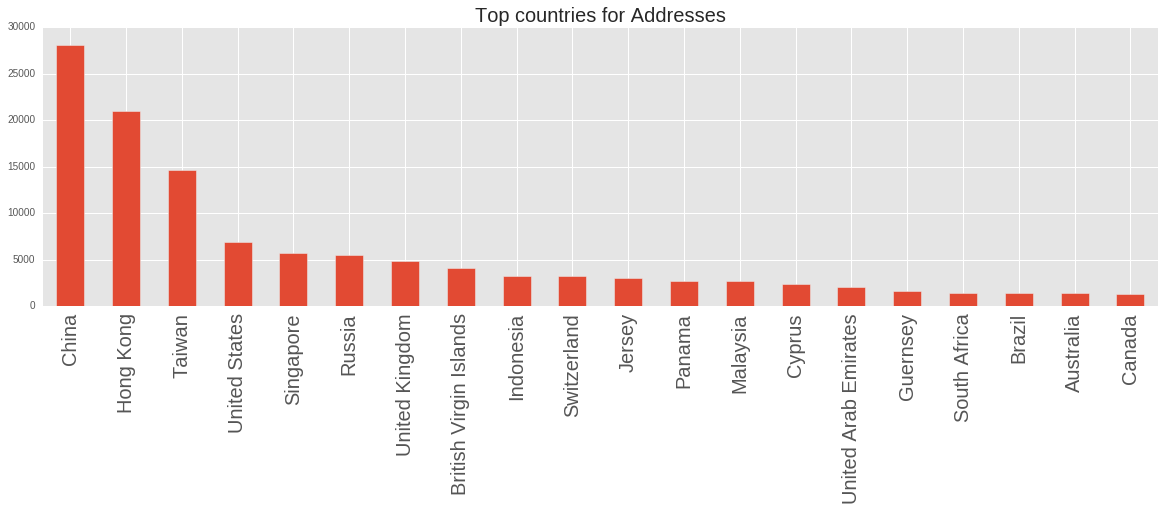

In [7]:
# as another example, let's look the top 20 countries for each of the node types

adds.countries.value_counts()[:20].plot(kind="bar", figsize=(20,5))
plt.title("Top countries for Addresses", fontsize=20)
plt.xticks(fontsize=20);

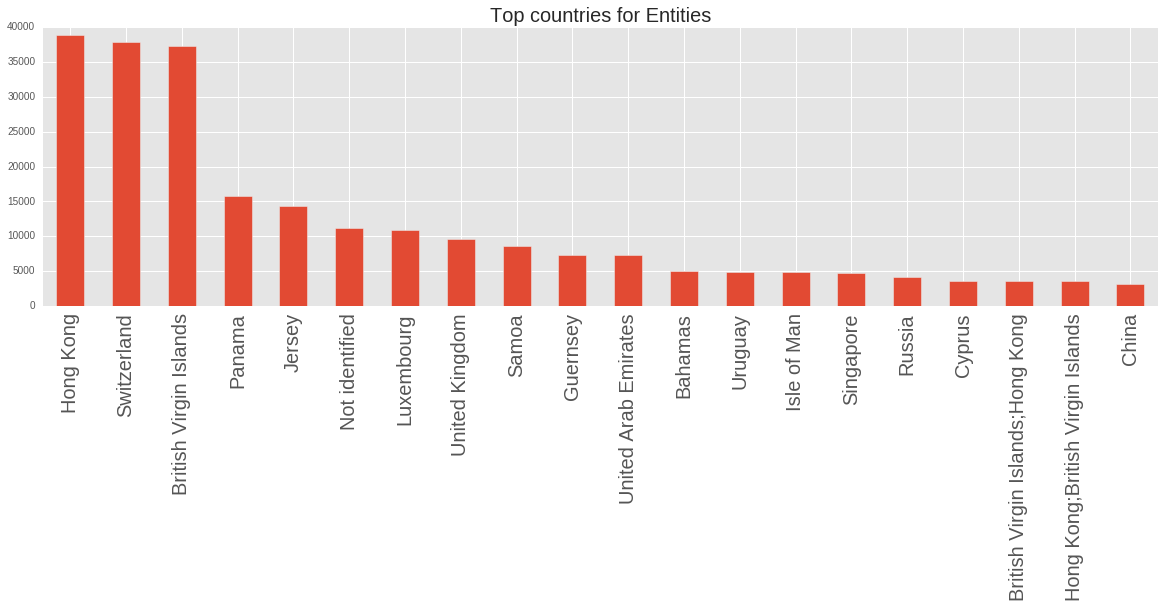

In [8]:
ents.countries.value_counts()[:20].plot(kind="bar", figsize=(20,5))
plt.title("Top countries for Entities", fontsize=20)
plt.xticks(fontsize=20);

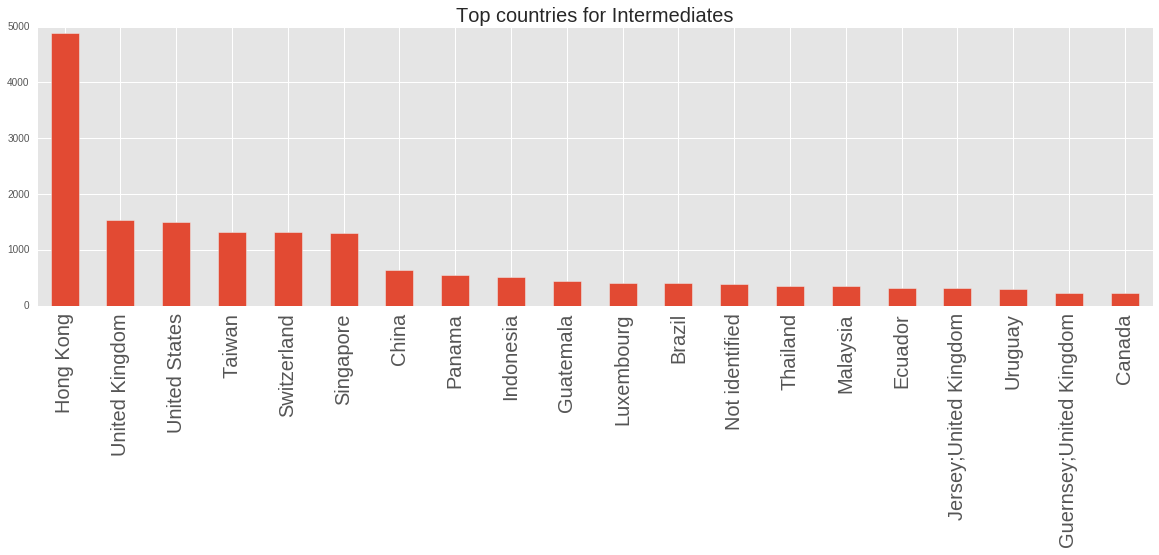

In [9]:
inter.countries.value_counts()[:20].plot(kind="bar", figsize=(20,5))
plt.title("Top countries for Intermediates", fontsize=20)
plt.xticks(fontsize=20);

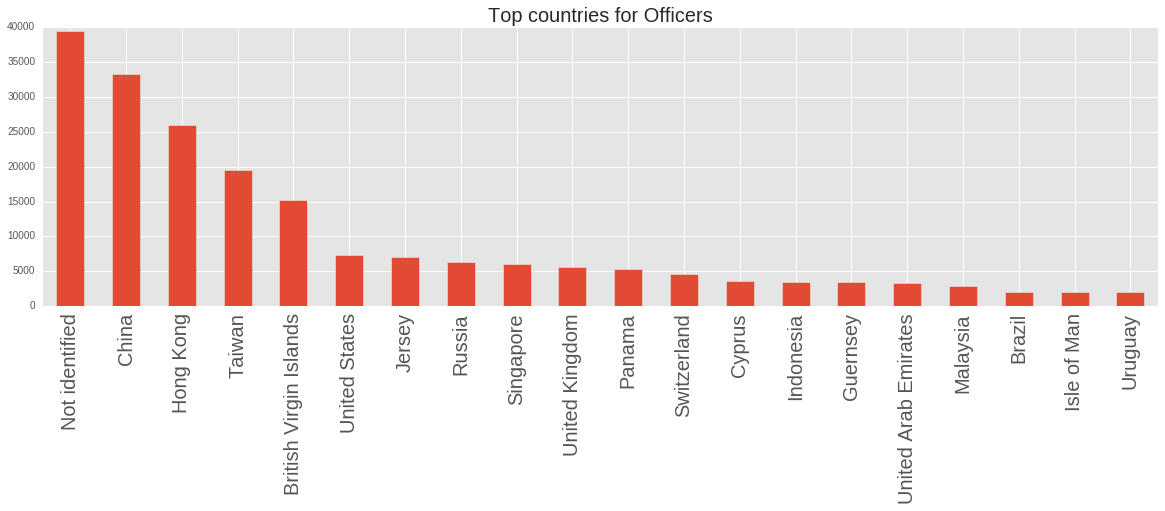

In [3]:
offi.countries.value_counts()[:20].plot(kind="bar", figsize=(20,5))
plt.title("Top countries for Officers", fontsize=20)
plt.xticks(fontsize=20);

# Working with the Graph

In [11]:
# create graph

G = nx.DiGraph()

for n,row in adds.iterrows():
    G.add_node(row.node_id, node_type="address", details=row.to_dict())
    
for n,row in ents.iterrows():
    G.add_node(row.node_id, node_type="entities", details=row.to_dict())
    
for n,row in inter.iterrows():
    G.add_node(row.node_id, node_type="intermediates", details=row.to_dict())
    
for n,row in offi.iterrows():
    G.add_node(row.node_id, node_type="officers", details=row.to_dict())
    
for n,row in edges.iterrows():
    G.add_edge(row.node_1, row.node_2, rel_type=row.rel_type, details={})

In [12]:
print("Number of nodes: {}".format(G.number_of_nodes()))
print("Number of edges: {}".format(G.number_of_edges()))

# Merge similar nodes
merge_similar_names(G)
print("After Merge")

print("Number of nodes: {}".format(G.number_of_nodes()))
print("Number of edges: {}".format(G.number_of_edges()))

Number of nodes: 838295
Number of edges: 1212945
After Merge
Number of nodes: 813423
Number of edges: 1133028


We can now look at whether the graph we are looking at is fully connected or not. NetworkX makes this easy.

In [13]:
# get all connected subgraphs
subgraphs = [g for g in nx.connected_component_subgraphs(G.to_undirected())]

# sort by number of nodes in each
subgraphs = sorted(subgraphs, key=lambda x: x.number_of_nodes(), reverse=True)

# take a look
print([s.number_of_nodes() for s in subgraphs[:10]])

[708807, 728, 644, 597, 521, 409, 398, 378, 378, 372]


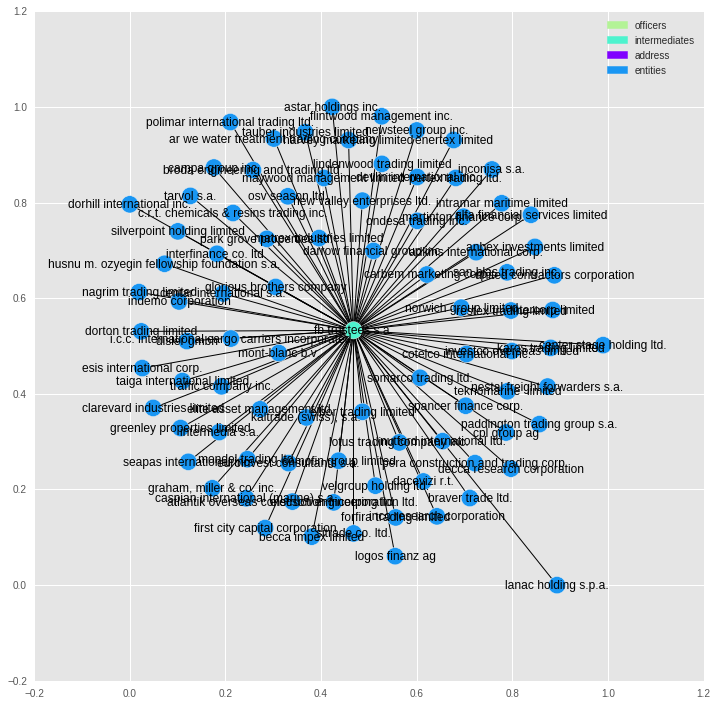

In [14]:
plot_graph(subgraphs[134], figsize=(12,12))

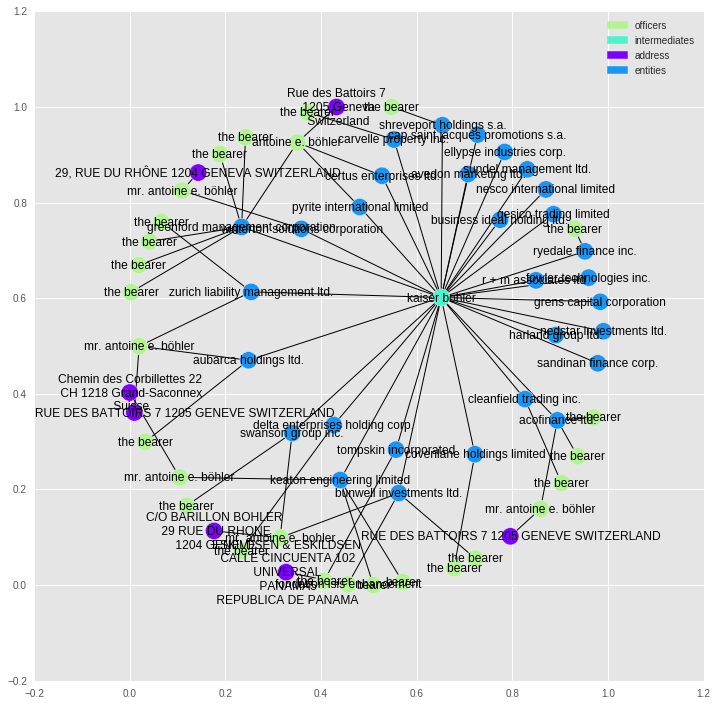

In [15]:
plot_graph(subgraphs[206], figsize=(12,12))

# The Main Network

Visualising small networks is difficult even with these few nodes. Using the same approach for largest connected subgraph is infeasable. Instead we are going to have to use other methods.

In [16]:
# grab the largest subgraph
g = subgraphs[0]

## Node degree
We might guess that the number of connections a node has (it's degree) is related to how important it is within the network. Let's take a look.

In [17]:
# look at node degree

# first get the details of the graph
nodes = g.nodes()
g_degree = g.degree()
types = [g.node[n]["node_type"] for n in nodes]
degrees = [g_degree[n] for n in nodes]
names = [get_node_label(g.node[n]) for n in nodes]

# then load into a dataframe for easy manipulation
node_degree = pd.DataFrame(data={"node_type":types, "degree":degrees, "name": names}, index=nodes)

# how many by node_type
node_degree.groupby("node_type").agg(["count", "mean", "median"])

degree                  
                count       mean median
node_type                              
address        137419   2.078883      1
entities       274639   3.048489      2
intermediates   10747  25.460315      3
officers       286002   2.356858      2

In [18]:
# look at the top 15
node_degree.sort_values("degree", ascending=False)[0:15]

,degree,name,node_type
236724,37329,Portcullis TrustNet Chambers P.O. Box 3444 Roa...,address
54662,36115,portcullis trustnet (bvi) limited,officers
11001746,7014,orion house services (hk) limited,intermediates
288469,5697,Unitrust Corporate Services Ltd. John Humphrie...,address
298333,5695,unitrust corporate services ltd.,intermediates
11011863,4356,mossack fonseca & co.,intermediates
96909,4253,portcullis trustnet (samoa) limited,officers
11012037,4112,prime corporate solutions sarl,intermediates
11001708,4094,offshore business consultant (int'l) limited,intermediates
285729,3894,"Sealight Incorporations Limited Room 1201, Con...",address


Given that the Intermediary appears to be a middleman that helps create the entities, it is easy to consider that each one could be linked to many entities. What isn't immediately clear is how they might be linked together. Let's take a look at the shortest path between "portcullis trustnet (bvi) limited" and "unitrust corporate services ltd.":

In [19]:
def plot_path(g, path):
    plot_graph(g.subgraph(path), label_edges=True, figsize=(12,12))

path = nx.shortest_path(g, source=54662, target=298333)

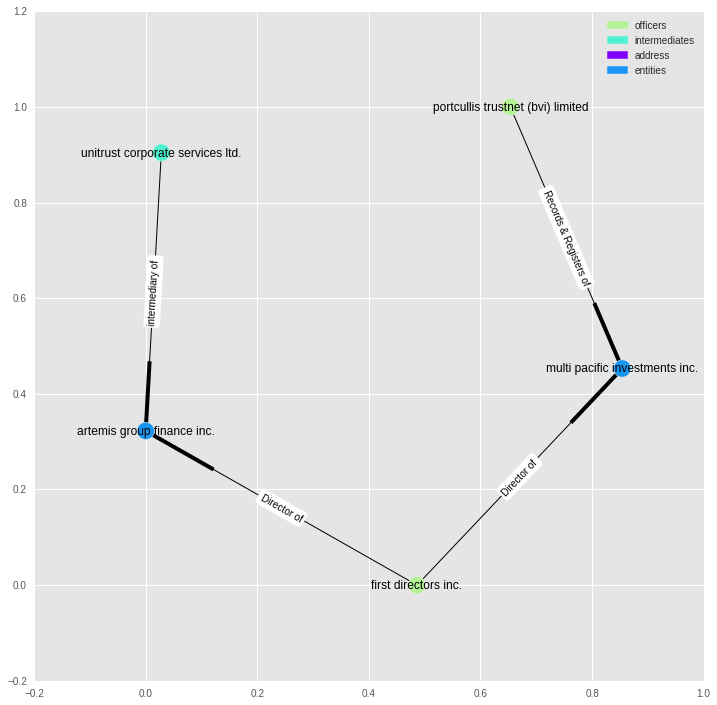

In [20]:
plot_path(G, path)

It seems that the two intermediaries are linked together through companies who share a common director, ["first directors inc"](https://en.wikipedia.org/wiki/Nominative_determinism). As it’s name suggests, it also acts as director for a number of other companies:

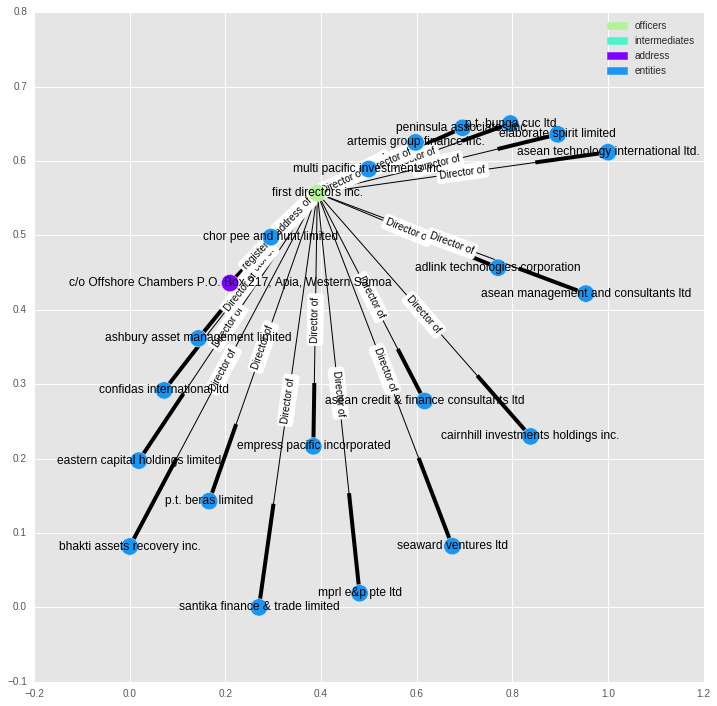

In [21]:
plot_graph(G.subgraph(nx.ego_graph(g, 24663, radius=1).nodes()), label_edges=True, figsize=(12,12))

We can do the same for, say, "mossack fonseca & co." and "sealight incorporations limited":

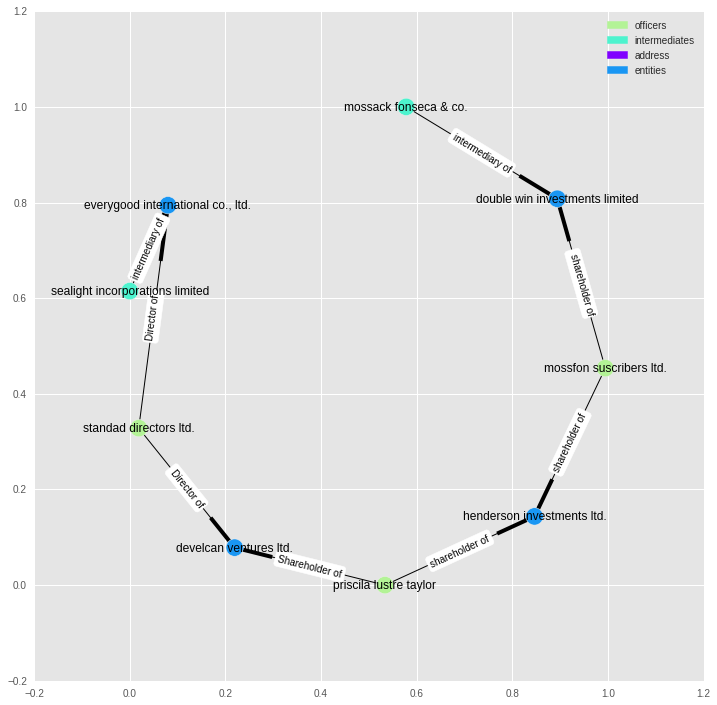

In [22]:
path = nx.shortest_path(g,11011863, 298293)
plot_path(G, path)

## Degree Distribution

We can also ask how the degree of the graph is distributed.

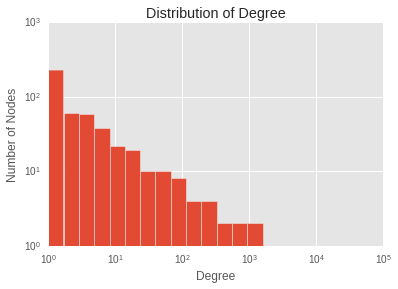

In [23]:
max_bin = max(degrees)
n_bins = 20
log_bins = [10 ** ((i/n_bins) * np.log10(max_bin)) for i in range(0,n_bins)]
fig, ax = plt.subplots()
node_degree.degree.value_counts().hist(bins=log_bins,log=True)
ax.set_xscale('log')

plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.title("Distribution of Degree");

# Page Rank Importance
Previously we used node-degree as a proxy for the "importance" of a node. There are others. A well known example is [Page rank](https://en.wikipedia.org/wiki/PageRank).

In [24]:
pr = nx.pagerank_scipy(g)
node_degree["page_rank"] = node_degree.index.map(lambda x: pr[x])
node_degree.sort_values("page_rank", ascending=False)[0:15]

,degree,name,node_type,page_rank
236724,37329,Portcullis TrustNet Chambers P.O. Box 3444 Roa...,address,0.007766
54662,36115,portcullis trustnet (bvi) limited,officers,0.007553
11001746,7014,orion house services (hk) limited,intermediates,0.002151
11001708,4094,offshore business consultant (int'l) limited,intermediates,0.001420
11012037,4112,prime corporate solutions sarl,intermediates,0.001271
11008027,3887,mossack fonseca & co. (singapore) pte ltd.,intermediates,0.001180
96909,4253,portcullis trustnet (samoa) limited,officers,0.001013
12174256,3885,mossfon suscribers ltd.,officers,0.000963
11009139,2036,mossack fonseca & co. (peru) corp.,intermediates,0.000908
11011863,4356,mossack fonseca & co.,intermediates,0.000759


As it turns out, page rank picks out similar nodes to looking at degree. 

If I were interested in identifying the main players in setting up offshore companies, these are the intermediates that I would start looking at first.

So what happens if we look at the page rank, but just for entities?

In [25]:
top_pr_entity = (node_degree[node_degree.node_type == "entities"]
                 .sort_values("page_rank", ascending=False)
                 .iloc[15]
                 .name)

t = nx.ego_graph(g, top_pr_entity, radius=1)

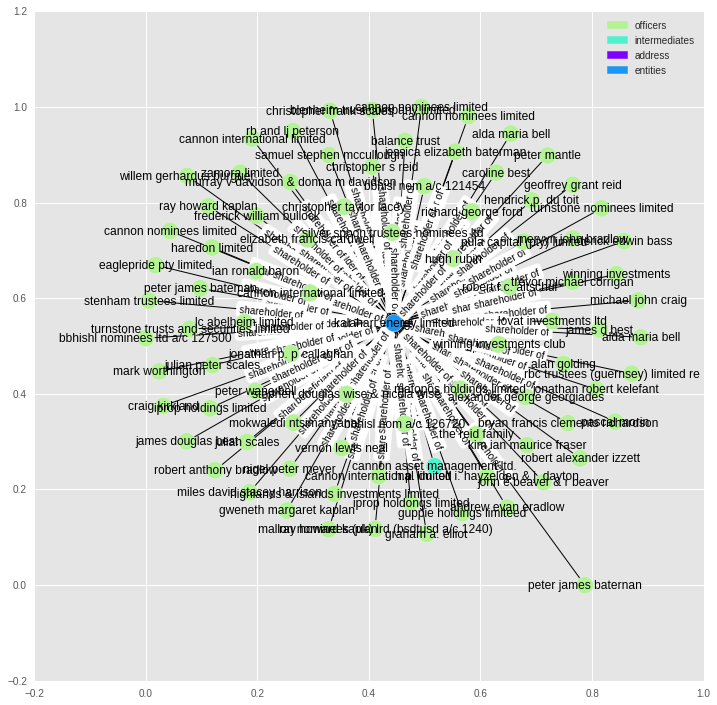

In [26]:
plot_graph(t, label_edges=True, figsize=(12,12))

# Clustering
Another measurement we can make of the "shape" of a graph is its clustering coefficient. For each node, this measures how connected its neighbours are with each other. You can think of it as a measure of the local structure of the graph: what fraction of a node's neighbours are also neighbours of each other.

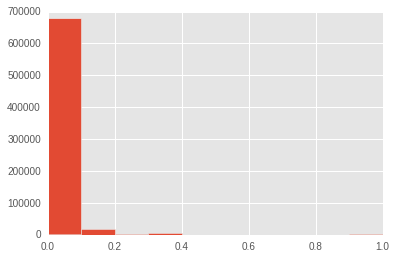

In [27]:
cl = nx.clustering(g)
node_degree["clustering_coefficient"] = node_degree.index.map(lambda x: cl[x])
node_degree.clustering_coefficient.hist()

As it turns out, there isn't much structure. Most nodes have clustering coefficients of zero. The few that have non-zero values tend to have low degrees. This means that the panama paper network isn't an example of a small world network. To see what's happening in the few non-zero cases, we can look at an example sub-graph below:

In [28]:
t = nx.ego_graph(g, 122762, radius=1)

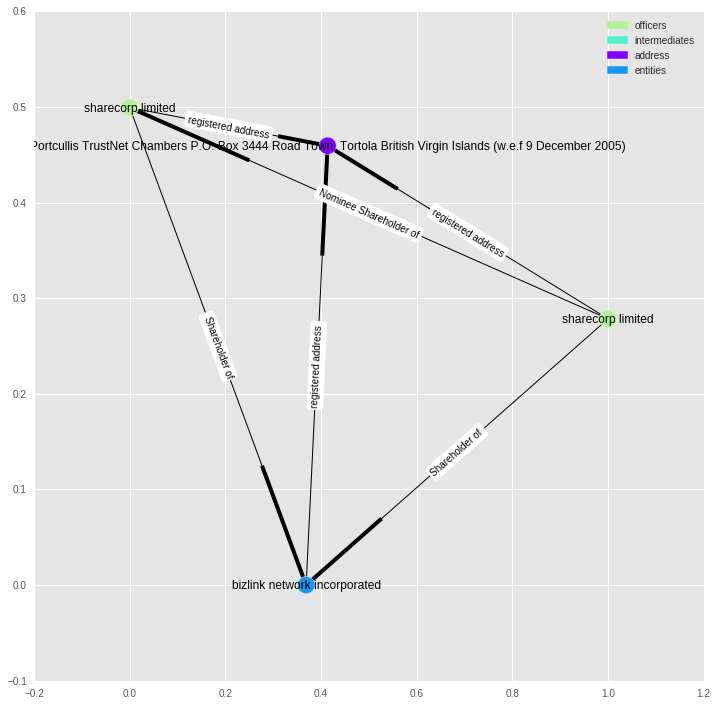

In [29]:
plot_graph(G.subgraph(t), label_edges=True, figsize=(12,12))

## Ownership

So far we have looked at the fully connected graph, even with connections like "address of" and "intermediary of". While this does tell us that there has been nearly 40,000 businesses registered to a single address, we might want to confine ourselves to just looking at the network formed where there is some form of ownership.

Unlike our previous graph, we are going to make this one directed - this mean that each edge has a direction associated with it. For example the relationship "shareholder of" acts in one direction.

In [30]:
owner_rels = set({
    'shareholder of',
    'Shareholder of',
    'Director / Shareholder of',
    'Director of',
    'Director (Rami Makhlouf) of',
    'Power of Attorney of',
    'Director / Shareholder / Beneficial Owner of',
    'Member / Shareholder of',
    'Owner of',
    'Beneficial Owner of',
    'Power of attorney of',
    'Owner, director and shareholder of',
    'President - Director of',
    'Sole shareholder of',
    'President and director of',
    'Director / Beneficial Owner of',
    'Power of Attorney / Shareholder of',
    'Director and shareholder of',
    'beneficiary of',
    'President of',
    'Member of Foundation Council of',
    'Beneficial owner of',
    'Sole signatory of',
    'Sole signatory / Beneficial owner of',
    'Principal beneficiary of',
    'Protector of',
    'Beneficiary, shareholder and director of',
    'Beneficiary of',
    'Shareholder (through Julex Foundation) of',
    'First beneficiary of',
    'Authorised Person / Signatory of',
    'Successor Protector of',
    'Register of Shareholder of',
    'Reserve Director of',
    'Resident Director of',
    'Alternate Director of',
    'Nominated Person of',
    'Register of Director of',
    'Trustee of Trust of',
    'Personal Directorship of',
    'Unit Trust Register of',
    'Chairman of',
    'Board Representative of',
    'Custodian of',
    'Nominee Shareholder of',
    'Nominee Director of',
    'Nominee Protector of',
    'Nominee Investment Advisor of',
    'Nominee Trust Settlor of',
    'Nominee Beneficiary of',
    'Nominee Secretary of',
    'Nominee Beneficial Owner of'
});

In [31]:
# copy main graph
g2 = G.copy()

# remove non-ownership edges
for e in g2.edges(data=True):
    if e[2]["rel_type"] not in owner_rels:
        g2.remove_edge(e[0], e[1])
        
# get all subgraphs
subgraphs = [sg for sg in nx.connected_component_subgraphs(g2.to_undirected())]
subgraphs = sorted(subgraphs, key=lambda x: x.number_of_nodes(), reverse=True)
len(subgraphs)

401655

Removing two thirds of the nodes breaks this graph into lots of smaller sub-graphs. Most of these graphs are uninteresting and simply reflect that one company is owned by a large number of shareholders. Consider the graph below:

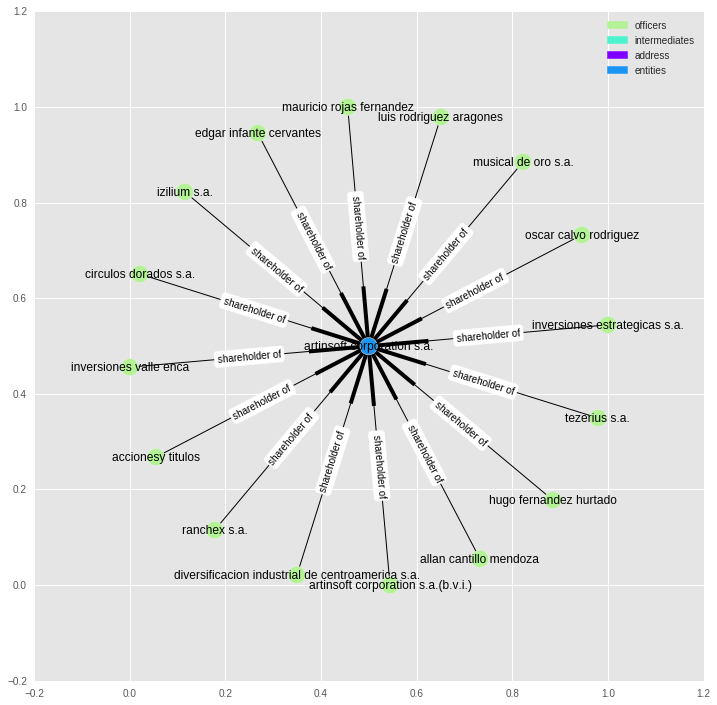

In [32]:
plot_graph(g2.subgraph(subgraphs[1000].nodes()), label_edges=True, figsize=(12,12))

To identify more interesting structures, we can look at sub-graphs with the largest median node degree:

In [33]:
avg_deg = pd.Series(data=[np.median(list(sg.degree().values())) for sg in subgraphs],
                    index=range(0,len(subgraphs)))

avg_deg.sort_values(ascending=False)[:10]

790     6.0
582     6.0
268     5.0
2643    5.0
2040    5.0
263     4.5
1420    4.0
1904    4.0
745     4.0
3271    4.0
dtype: float64

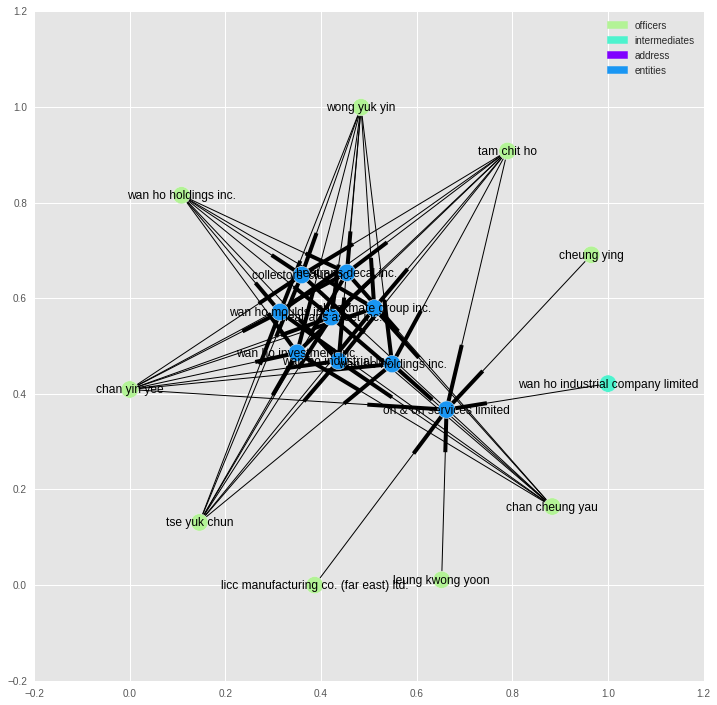

In [34]:
plot_graph(g2.subgraph(subgraphs[790].nodes()), figsize=(12,12))

## The Longest Line

We can also ask what the longest chain of ownership links is:

In [35]:
lp = nx.dag_longest_path(g2)
print("The longest path is {} nodes long.".format(len(lp)))

The longest path is 4 nodes long.


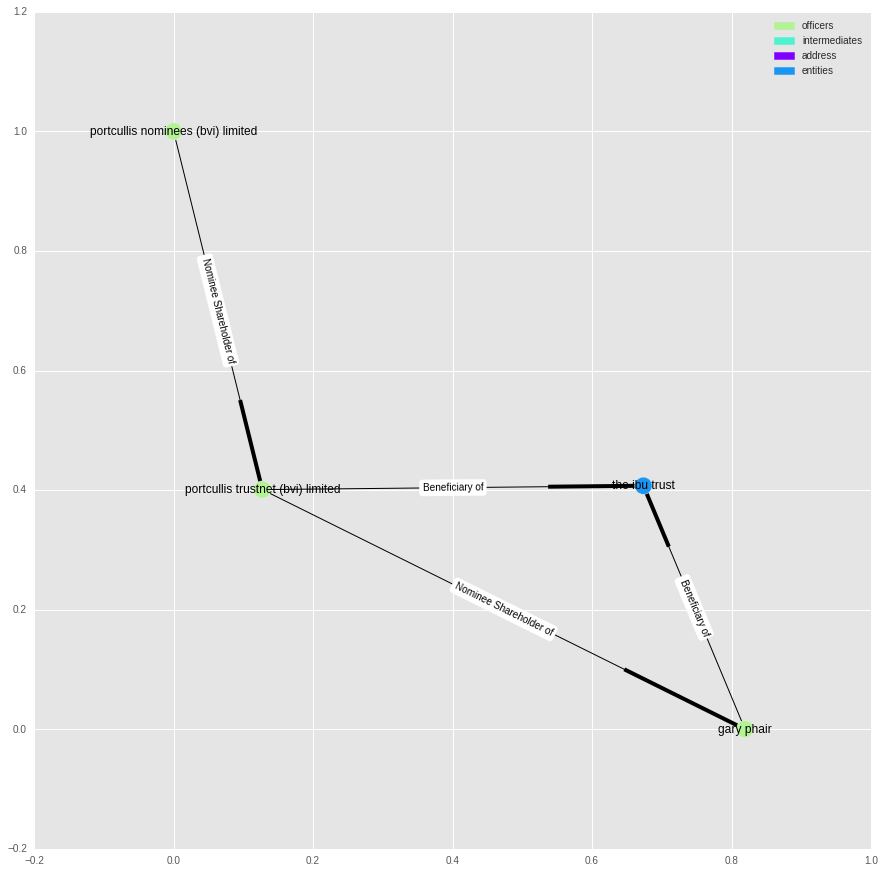

In [36]:
plot_graph(g2.subgraph(lp), label_edges=True)

# Community detection

We also apply community detection algorithms to the graph

In [37]:
from community import community_louvain

partition = community_louvain.best_partition(g)

print("Community Modularity: {}".format(community_louvain.modularity(partition, g)))
print("Number of detected communities: {}".format(len(set(partition.values()))))

Community Modularity: 0.9165327131379379
Number of detected communities: 2168


I put the partitions again into a dataframe for easy explorations.

In [38]:
part = (pd.Series(partition, name="partition")
        .reset_index()
        .rename(columns={"index":"node"}))

We can look at the distribution of the sizes of the communities (note the log):

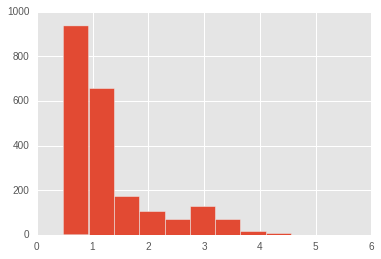

In [39]:
part.groupby("partition").size().apply(np.log10).hist()

In [40]:
# create a tempory dataframe of the sizes of each partition
t = part.groupby("partition").size()

# and select a random one with a small enough size it can be visualised
nid = np.random.choice(t[(t>10) &(t<200)].index.values)
print("Chosen node id: {}".format(nid))

# get the nodes for this partition
target_nodes = part[part.partition == nid].node.values

# print a quick description
for des in ([(g.node[n]["node_type"], g.node[n]["details"]["countries"]) for n in target_nodes]):
    print(des)

Chosen node id: 360
('officers', 'Hong Kong')
('officers', 'Hong Kong')
('officers', 'Hong Kong')
('officers', 'Singapore')
('officers', 'Hong Kong')
('officers', 'Singapore')
('entities', 'British Virgin Islands')
('address', 'Singapore')
('address', 'Hong Kong')
('address', 'Hong Kong')
('address', 'Singapore')
('address', 'Hong Kong')


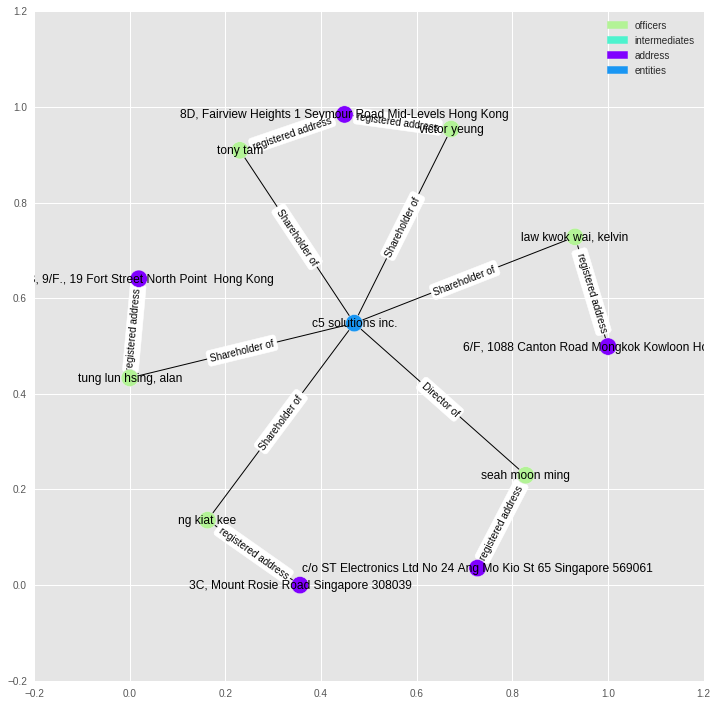

In [41]:
plot_graph(g.subgraph(part[part.partition == nid].node.values), label_edges=True, figsize=(12,12))

# Questions?